In [4]:
import pandas as pd
from get_tensor import get_samples, get_batch, display_image_axle, display_image, get_timestamp
import imageio
import numpy as np
import time, os, torch, math
import matplotlib.pyplot as plt
from cnn_models.model_templates import SkylightData
import random

In [7]:
skies_data = pd.read_csv("other_data\coords-scattered-hdr.csv")
skies_data

,Date,Time,SunAzimuth,SunAltitude,SamplePatternIndex,SampleAzimuth,SampleAltitude,SunPointAngle,ColorA5,ColorB5,...,1773,1774,1775,1776,1777,1778,1779,1780,u,v
0,11/6/2012,12:32:26,191.9511,30.5111,0,0.00,12.1151,135.851,0,1,...,0.003172,0.002996,0.002875,0.002726,0.002590,0.002480,0.002348,0.002258,0.500000,0.951278
1,11/6/2012,12:32:26,191.9511,30.5111,1,348.75,12.1151,131.887,0,1,...,0.000429,0.000456,0.000420,0.000399,0.000385,0.000342,0.000355,0.000359,0.411960,0.942607
2,11/6/2012,12:32:26,191.9511,30.5111,2,337.50,12.1151,126.019,0,1,...,0.000198,0.000197,0.000231,0.000260,0.000254,0.000194,0.000153,0.000107,0.327303,0.916927
3,11/6/2012,12:32:26,191.9511,30.5111,3,326.25,12.1151,118.799,0,1,...,0.000445,0.000406,0.000392,0.000370,0.000339,0.000293,0.000316,0.000333,0.249283,0.875224
4,11/6/2012,12:32:26,191.9511,30.5111,4,315.00,12.1151,110.660,0,1,...,0.000745,0.000717,0.000689,0.000618,0.000597,0.000655,0.000644,0.000641,0.180898,0.819102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16370,9/26/2013,15:40:01,244.1781,23.4249,76,225.00,71.9187,49.692,0,0,...,0.000186,0.000163,0.000130,0.000120,0.000112,0.000106,0.000118,0.000123,0.419001,0.419001
16371,9/26/2013,15:40:01,244.1781,23.4249,77,270.00,71.9187,50.634,0,0,...,0.002164,0.002111,0.002037,0.001972,0.001907,0.001828,0.001788,0.001735,0.385450,0.500000
16372,9/26/2013,15:40:01,244.1781,23.4249,78,315.00,71.9187,61.870,0,0,...,0.010306,0.010025,0.009749,0.009450,0.009159,0.008849,0.008572,0.008330,0.419001,0.580999
16373,9/26/2013,15:40:01,244.1781,23.4249,79,0.00,71.9187,75.293,0,0,...,0.004649,0.004518,0.004371,0.004213,0.004082,0.003955,0.003848,0.003759,0.500000,0.614550


In [8]:
def row_to_imagepaths(row):
    timestamp = get_timestamp(row)
    
    time_obj = time.strptime(timestamp, "%m/%d/%Y %H:%M:%S")
    date_dir = time.strftime("%Y-%m-%d", time_obj)
    time_dir = time.strftime("%H.%M.%S", time_obj)

    entries = os.scandir(f"D:\skies\\{date_dir}\\HDR\\{time_dir}")
    jpgs = [
        entry.path
        for entry in entries
        if entry.is_file() and os.path.splitext(entry.name)[-1].lower() == ".jpg"
    ]
    jpgs.sort()

    return jpgs[:8]


def get_samples_mod(row, radius=50, circle_thickness=5):
    images = row_to_imagepaths(row)
    image_arrs = torch.from_numpy(imageio.imread(images[6])).permute(2, 0, 1)
    
    channels = int(image_arrs.shape[0])
    height = int(image_arrs.shape[1])
    width = int(image_arrs.shape[2])
    crop_index = int((width - height) / 2)
    image_arrs = image_arrs[:, :, crop_index:crop_index + height]
    
    x = int(row["u"] * height)
    y = int(row["v"] * height)

    for j in range(image_arrs.shape[1]):
        for k in range(image_arrs.shape[2]):
            y_offset = abs(j - y)
            x_offset = abs(k - x)
            distance = math.hypot(x_offset, y_offset)
            if distance < radius + circle_thickness and distance > radius :
                image_arrs[:, j, k] = torch.tensor([255, 0, 0])
    
    return image_arrs, (get_samples(row).cpu()[18:21] * 255).to(torch.uint8), x, y

def torch_to_imageio(image_tensor):
    return image_tensor.permute(1, 2, 0).numpy()

In [10]:
# cloudy: 12211
# edge (works well): 10
# cloudy-edge: 11707
# clear: 2543
# cloud traces: 1519

#i = random.randint(0, skies_data.shape[0])
i = 2000

print(i)
src = skies_data.iloc[i]
source_img, sample, x_sample, y_sample = get_samples_mod(src, circle_thickness=10)
source_img.shape, sample.shape

2000


(torch.Size([3, 2912, 2912]), torch.Size([3, 100, 100]))

In [11]:
predicted_data = model.predict_spectral_radiance(get_samples(src))\
                        .reshape(-1).numpy()

wavelengths = [number for number in range(350, 1780 + 1)]
plt.xlabel("Wavelength (nm)")
plt.plot(wavelengths, src[map(str, wavelengths)], "silver", label="Ground Truth")
plt.plot(wavelengths, predicted_data, "gold", label="Prediction")
plt.legend()
plt.savefig("other_data\spectral_radiance.png", dpi=400)

NameError: name 'model' is not defined

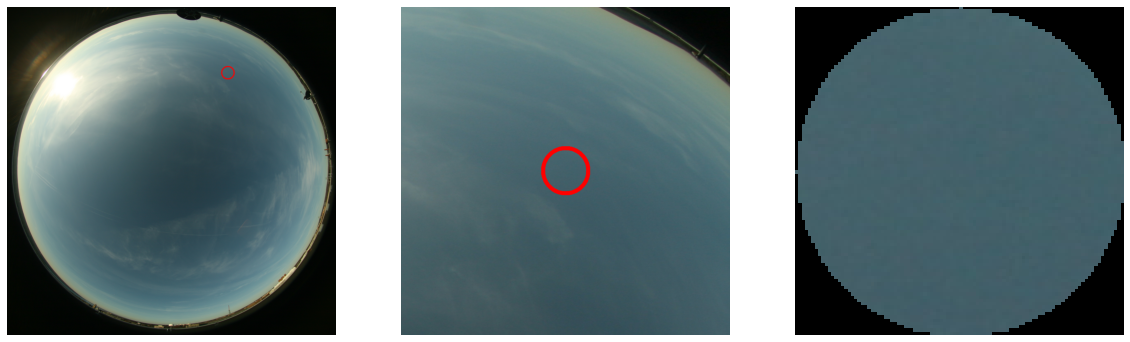

In [14]:
def zoom_in(image_tensor, x, y, zoom_size=400):
    return image_tensor[
        :,
        max(0, y-zoom_size):min(2912, y+zoom_size),
        max(0, x-zoom_size):min(2912, x+zoom_size)
    ]

def show_image(ax, img_tensor):
    ax.axis('off')
    display_image_axle(ax, img_tensor)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
show_image(ax1, source_img)
show_image(ax2, zoom_in(source_img, x_sample, y_sample))
show_image(ax3, sample)

In [15]:
if True:
    imageio.imwrite("other_data/complete_sky.png", torch_to_imageio(source_img))
    imageio.imwrite("other_data/partial_sky.png", torch_to_imageio(zoom_in(source_img, x_sample, y_sample)))
    imageio.imwrite("other_data/sample.png", torch_to_imageio(sample))